# Importing package

In [34]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC
import xgboost as xgb
import warnings
import plotly.figure_factory as ff
import plotly.graph_objs as go

In [35]:
warnings.filterwarnings("ignore", category=UserWarning)

In [36]:
#   Load the data
data = 'star_classification.csv'
df = pd.read_csv(data)

The data consists of 100,000 observations of space taken by the SDSS (Sloan Digital Sky Survey). Every observation is described by 17 feature columns and 1 class column which identifies it to be either a star, galaxy or quasar.

- obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
- alpha = Right Ascension angle (at J2000 epoch)
- delta = Declination angle (at J2000 epoch)
- u = Ultraviolet filter in the photometric system
- g = Green filter in the photometric system
- r = Red filter in the photometric system
- i = Near Infrared filter in the photometric system
- z = Infrared filter in the photometric system
- run_ID = Run Number used to identify the specific scan
- rereun_ID = Rerun Number to specify how the image was processed
- cam_col = Camera column to identify the scanline within the run
- field_ID = Field number to identify each field
- spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
- class = object class (galaxy, star or quasar object)
- redshift = redshift value based on the increase in wavelength
- plate = plate ID, identifies each plate in SDSS
- MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
- fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observatio

# Info and vizualization

In [37]:
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [39]:
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


<Axes: xlabel='class'>

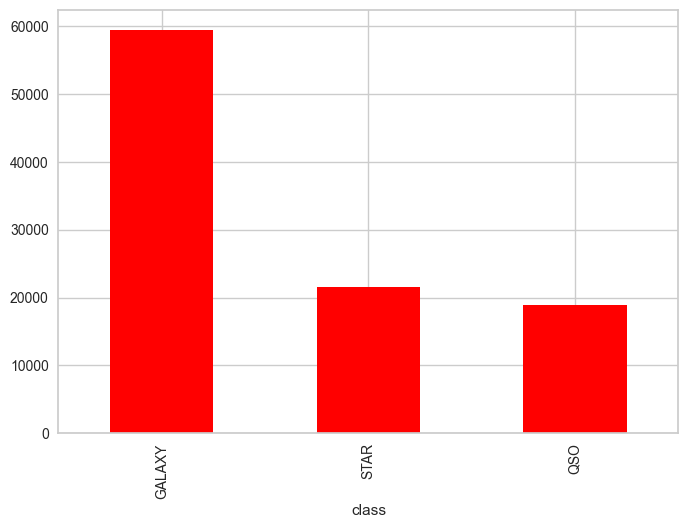

In [40]:
df["class"].value_counts().plot(kind='bar', color='red')

transform text to number  like GALAXY=0 STAR=1 QSO=2

In [41]:
from plotly import graph_objects as go
class_counts = df["class"].value_counts()
colors = ['#48678b', '#748db4', '#b3c1d2']
pull = [0.015, 0.025, 0.025] 
fig = go.Figure(data=[go.Pie(labels=class_counts.index,
                             values=class_counts.values,
                             pull=pull,
                             marker_colors=colors,
                             textinfo='percent+label',
                             textfont=dict(family='Times New Roman', size=12),
                             )])
fig.update_layout(title_text='Percentage Distribution of Class Types',
                  title_font=dict(family='Times New Roman', size=16),
                  )
fig.show()

In [42]:
df["class"] = [0 if i == 'GALAXY' else 1 if i == 'STAR' else 2 for i in df["class"]]

<Axes: xlabel='class'>

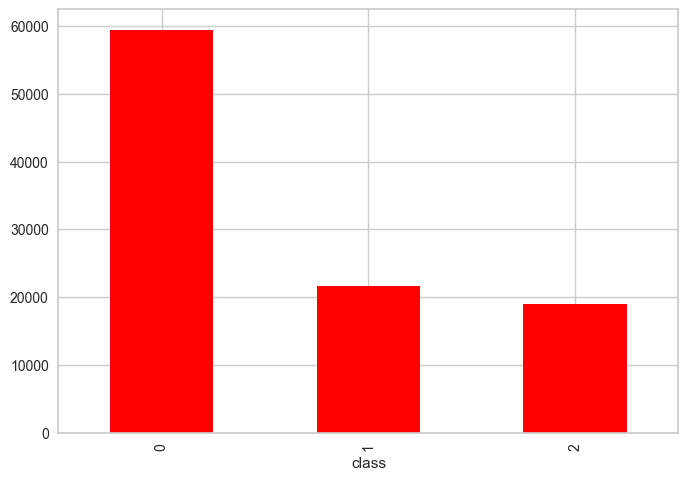

In [43]:
df["class"].value_counts().plot(kind='bar', color='red')

Ici, le code utilise l'algorithme LOF pour calculer des scores de valeurs aberrantes pour chaque point de données dans le DataFrame df. En définissant un seuil, il filtre les points de données dont les scores sont inférieurs au seuil, les considérant comme des valeurs aberrantes. Cette approche permet d'automatiser le processus de détection des valeurs aberrantes dans les données.

In [44]:
lof = LocalOutlierFactor()
y_pred = lof.fit_predict(df)
x_score = lof.negative_outlier_factor_
outlier_score = pd.DataFrame()
outlier_score["score"] = x_score

# threshold
threshold = -1.5
filtre = outlier_score["score"] < threshold
outlier_index = outlier_score[filtre].index.tolist()
len(outlier_index)

15256

In [45]:
df.drop(outlier_index, inplace = True)

# Clasificatioon

ce code crée une carte de chaleur pour visualiser la corrélation entre les variables du DataFrame df. Cette visualisation est utile pour identifier les relations linéaires entre les variables et pour comprendre la structure des données.

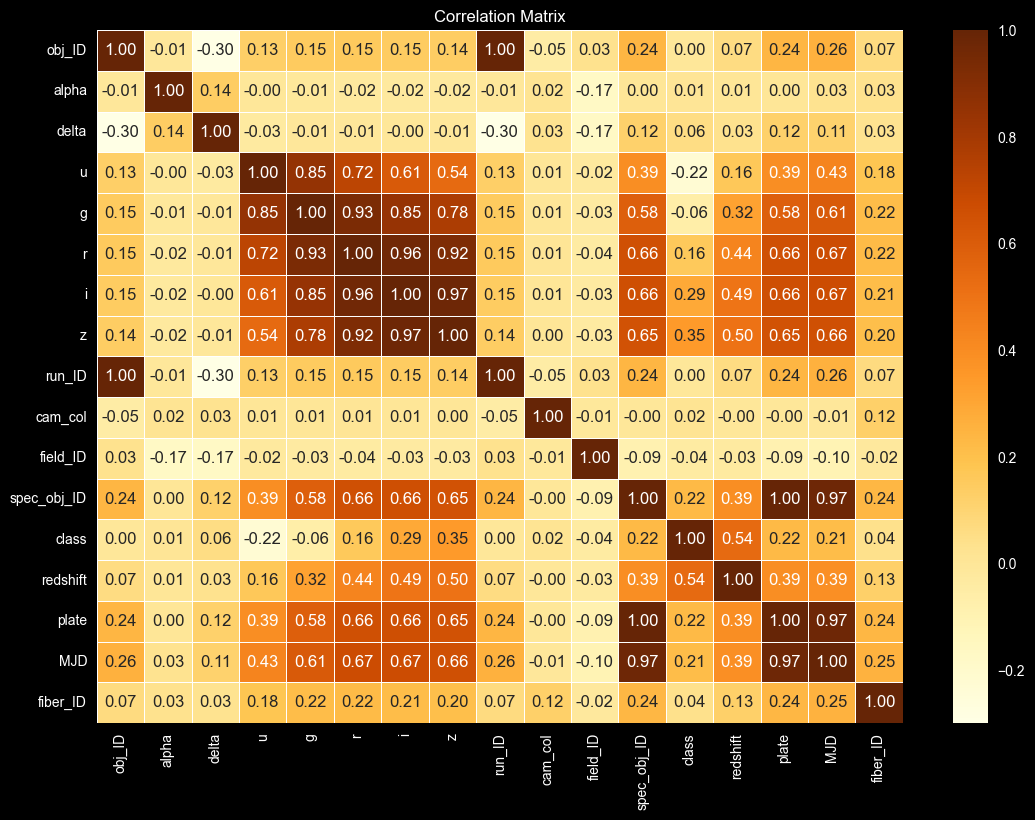

In [46]:
df = df.drop(['rerun_ID'], axis=1)
corr = df.corr()

# Creating a figure and an axis with a specific size
f, ax = plt.subplots(figsize=(13, 9))

# Setting the background color of the axis
ax.set_facecolor('black')

# Generating a heatmap for the correlation matrix
# Store the heatmap object to access the colorbar
sns_heatmap = sns.heatmap(corr, cmap="YlOrBr", annot=True, linewidths=0.5, fmt='.2f', ax=ax)

# Setting the figure's background color
f.set_facecolor('black')

# Setting labels color
ax.set_xlabel(ax.get_xlabel(), color='white')
ax.set_ylabel(ax.get_ylabel(), color='white')

# Setting tick labels color for axes
ax.set_xticklabels(ax.get_xticklabels(), color='white')
ax.set_yticklabels(ax.get_yticklabels(), color='white')

# Setting tick labels color for the colorbar
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(color='white')

# Setting colorbar label color
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
ax.set_title('Correlation Matrix', color='white')
plt.show()


Ces valeurs représentent les corrélations entre la variable cible "class" et les autres variables du DataFrame df, triées par ordre croissant de corrélation. Voici ce que chaque partie de la sortie signifie :

Corrélation négative : Les variables avec des valeurs négatives sont négativement corrélées avec la variable cible "class". Cela signifie que lorsque ces variables augmentent, la probabilité que la classe soit "GALAXY" diminue. Plus la valeur absolue de la corrélation est élevée, plus la relation est forte. Par exemple, la variable "u" a une corrélation de -0.222802, ce qui indique une corrélation négative modérée avec la classe.

Corrélation positive : Les variables avec des valeurs positives sont positivement corrélées avec la variable cible "class". Cela signifie que lorsque ces variables augmentent, la probabilité que la classe soit "STAR" ou "QSO" (quasar) augmente. Encore une fois, une valeur absolue plus élevée indique une corrélation plus forte. Par exemple, la variable "redshift" a une corrélation de 0.541667, ce qui indique une corrélation positive forte avec la classe.

Corrélation nulle : Les variables avec des valeurs proches de zéro ont une corrélation nulle avec la variable cible "class". Cela signifie qu'elles ne sont pas linéairement liées à la variable cible.

NaN : La colonne "rerun_ID" a une corrélation de NaN, ce qui signifie qu'elle ne peut pas être calculée. Cela peut se produire si toutes les valeurs dans cette colonne sont identiques, ce qui rend la corrélation indéfinie.

En utilisant ces valeurs de corrélation, vous pouvez identifier les variables qui sont les plus fortement liées à la variable cible "class", ce qui peut être utile pour la modélisation et l'analyse des données. Par exemple, "redshift" semble être fortement corrélé à la classe, ce qui peut être une variable importante pour prédire la classe d'un objet.

In [47]:
corr['class'].sort_values()

u             -0.222802
g             -0.058192
field_ID      -0.037542
run_ID         0.000250
obj_ID         0.000252
alpha          0.008187
cam_col        0.017789
fiber_ID       0.037319
delta          0.058947
r              0.160654
MJD            0.214433
spec_obj_ID    0.224718
plate          0.224718
i              0.294075
z              0.349711
redshift       0.541667
class          1.000000
Name: class, dtype: float64

In [48]:
df = df.drop(['obj_ID','alpha','delta','run_ID','cam_col','field_ID','fiber_ID'], axis = 1)

In [49]:
x = df.drop(['class'], axis = 1)
y = df.loc[:,'class'].values

In [50]:
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()   
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Logistic Regression Accuracy: ", accuracy_score(y_test, y_pred))

Logistic Regression Accuracy:  0.9594865193449188


To improve the accuracy of our model, we are trying a different approach by using another model. By exploring different models, we aim to find one that can provide a higher accuracy for our task. This experimentation is part of our effort to enhance the performance of our predictions and achieve better results.
By implementing these strategies, we can aim to achieve a higher accuracy for our model and improve its performance in predicting the target variable.


### SVC (Support Vector Classifier)

Le classificateur SVC est un modèle d'apprentissage supervisé utilisé pour la classification. Il fonctionne en trouvant l'hyperplan qui sépare au mieux les différentes classes dans l'espace des caractéristiques. Le principe fondamental est de maximiser la marge entre les classes.

#### Fonctionnement :

1. Séparation des classes par un hyperplan dans un espace de dimension supérieure (défini par les caractéristiques).
2. Identification des vecteurs de support qui définissent l'hyperplan.
3. Utilisation d'un noyau pour gérer les données non linéairement séparables.

#### Avantages :

- Efficace dans les espaces de grande dimension.
- Bonne performance avec des marges de séparation claires.

#### Inconvénients :

- Sensible au choix du noyau et aux paramètres associés.
- Peut être coûteux en termes de calcul pour de grandes quantités de données.

### RandomForestClassifier

Le RandomForestClassifier est un modèle d'ensemble (ensemble learning) basé sur des arbres de décision. Il combine les prédictions de plusieurs arbres de décision pour obtenir une prédiction finale.

#### Fonctionnement :

1. Construction de multiples arbres de décision à partir d'échantillons de données bootstrap.
2. Utilisation d'une méthode de bagging pour agréger les prédictions des arbres individuels.
3. Sélection aléatoire des caractéristiques à chaque fractionnement de nœud.

#### Avantages :

- Robuste aux valeurs aberrantes et au sur-ajustement.
- Peut gérer efficacement les données avec des milliers de variables.

#### Inconvénients :

- Moins interprétable que les arbres de décision individuels.
- Peut être lent pour la prédiction sur de grandes quantités de données.

### XGBoostClassifier

XGBoostClassifier est une implémentation optimisée de l'algorithme de boosting appelé Gradient Boosting. Il est reconnu pour sa vitesse et sa performance dans les compétitions de data science.

#### Fonctionnement :

1. Construction séquentielle d'arbres de décision, où chaque arbre corrige les erreurs des précédents.
2. Utilisation de techniques de régularisation pour éviter le sur-ajustement.
3. Optimisation efficace des fonctions objectif et de perte.

#### Avantages :

- Extrêmement rapide et efficace.
- Performant sur une grande variété de problèmes de classification.

#### Inconvénients :

- Peut nécessiter un ajustement des hyperparamètres pour optimiser la performance.
- Moins interprétable que les modèles linéaires ou simples.

### Différences

- **SVC** est basé sur la recherche d'un hyperplan de séparation optimal, tandis que **RandomForestClassifier** et **XGBoostClassifier** utilisent des ensembles d'arbres de décision pour la classification.
- **RandomForestClassifier** construit des arbres de décision indépendants en parallèle, tandis que **XGBoostClassifier** construit des arbres séquentiellement en corrigeant les erreurs des précédents.
- **XGBoostClassifier** est souvent plus rapide et performant que **RandomForestClassifier** dans de nombreux cas, mais nécessite souvent plus de réglages d'hyperparamètres.


In [53]:
# Using Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [54]:
y_pred = clf.predict(X_test)
score = clf.score(X_test, y_test)
clf_score = np.mean(score)

print('Accuracy : %.3f' % (clf_score))

Accuracy : 0.980


In [55]:
df.head()

,u,g,r,i,z,spec_obj_ID,class,redshift,plate,MJD
0,23.87882,22.27530,20.39501,19.16573,18.79371,6.543777e+18,0,0.634794,5812,56354
1,24.77759,22.83188,22.58444,21.16812,21.61427,1.176014e+19,0,0.779136,10445,58158
3,22.13682,23.77656,21.61162,20.50454,19.25010,1.030107e+19,0,0.932346,9149,58039
4,19.43718,17.58028,16.49747,15.97711,15.54461,6.891865e+18,0,0.116123,6121,56187
6,21.46973,21.17624,20.92829,20.60826,20.42573,1.246262e+19,2,0.586455,11069,58456


In [56]:
X_test[0]

array([0.16844569, 0.9476133 , 1.23578433, 1.34487141, 1.45096406,
       1.50560427, 0.31697296, 1.50556689, 1.23067809])

In [57]:
def predict_celestial_object(features):
    """
    Prédit la classe d'un objet céleste basée sur ses caractéristiques, qui peuvent être fournies
    sous forme d'une liste de nombres ou d'une chaîne de caractères séparée par des virgules.

    Parameters:
    features : array-like ou str, shape (n_features,) ou "n1,n2,...,n_features"
        Les caractéristiques de l'objet céleste à classifier, soit sous forme d'une liste/array de nombres,
        soit sous forme d'une chaîne de caractères avec les nombres séparés par des virgules.

    Returns:
    str
        Le nom de la classe prédite (GALAXY, STAR, QSO).
    """
    # Convert the input to an array of floats
    if isinstance(features, str):
        features = np.array([float(n) for n in features.split(',')])
    elif isinstance(features, list):
        features = np.array(features)
    else:
        raise ValueError("Features must be a comma-separated string or a list of numbers.")

    # Ensure features are in the correct shape for prediction
    features = features.reshape(1, -1)

    # Standardize the features using the pre-fitted scaler
    features = scaler.transform(features)

    # Predict the class using the pre-trained classifier
    predicted_class = clf.predict(features)

    if predicted_class[0] == 0:
        return " it's a GALAXY"
    elif predicted_class[0] == 1:
        return "it's a STAR"
    else:
        return "it's a QSO"


# Example usage
# Replace these example features with actual features for prediction
example_features = "23.87882,22.27530,20.39501,19.16573,18.79371,6.543777e+18,0.634794,5812,56354"
print(predict_celestial_object(example_features))

 it's a GALAXY


Une matrice de confusion est un outil utilisé en apprentissage automatique pour évaluer les performances d'un modèle de classification. Elle est particulièrement utile lorsqu'on traite des problèmes où les classes sont déséquilibrées ou lorsque différents types d'erreurs ont différents coûts.

Voici comment cela fonctionne :

- Vrais positifs (TP) : Ce sont les cas où le modèle prédit correctement la classe positive.

- Vrais négatifs (TN) : Ce sont les cas où le modèle prédit correctement la classe négative.

- Faux positifs (FP) : Ce sont les cas où le modèle prédit à tort la classe positive alors qu'elle est en réalité négative. Aussi appelé erreur de type I.

- Faux négatifs (FN) : Ce sont les cas où le modèle prédit à tort la classe négative alors qu'elle est en réalité positive. Aussi appelé erreur de type II.

Avec ces composants, la matrice de confusion est généralement représentée sous forme de tableau, où les classes réelles sont sur un axe (généralement les lignes) et les classes prédites sont sur l'autre axe (généralement les colonnes).

Les principaux objectifs de l'utilisation d'une matrice de confusion sont :

Évaluation des performances : Elle fournit un décompte détaillé des performances du modèle, vous permettant de voir où il commet des erreurs.

Analyse des erreurs : Elle permet d'identifier quelles classes sont confondues entre elles, fournissant des informations sur les éventuelles faiblesses du modèle.

Sélection du modèle : Elle peut être utilisée pour comparer les performances de différents modèles et sélectionner celui qui convient le mieux au problème traité.

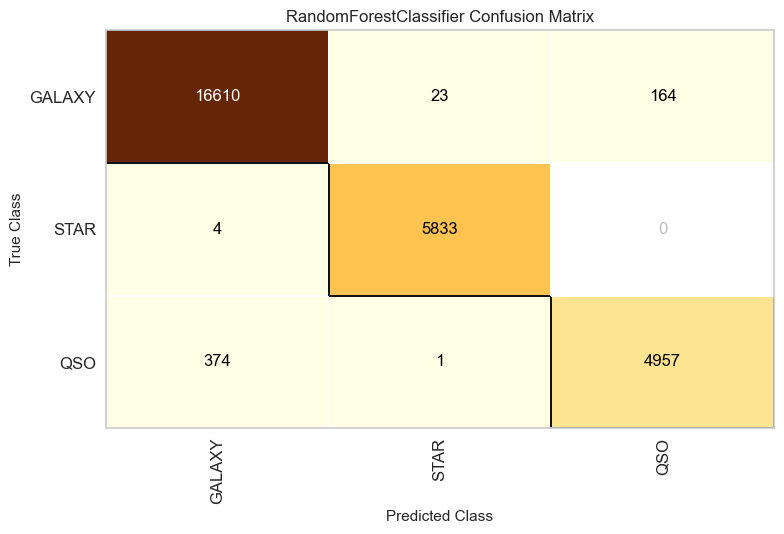

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [58]:
classes = ["GALAXY", "STAR", "QSO"]
r_forest_cm = ConfusionMatrix(clf, classes=classes, cmap='YlOrBr')

r_forest_cm.fit(X_train, y_train)
r_forest_cm.score(X_test, y_test)
r_forest_cm.show()


Un rapport de classification est un autre outil important utilisé en apprentissage automatique pour évaluer les performances d'un modèle de classification. Il fournit des mesures de performance plus détaillées que la simple analyse fournie par une matrice de confusion.

Voici les éléments principaux inclus dans un rapport de classification :

Précision (Precision) : C'est le nombre de vrais positifs divisé par le nombre total de prédictions positives du modèle. Il mesure la proportion de prédictions positives qui étaient réellement correctes.

Rappel (Recall) : C'est le nombre de vrais positifs divisé par le nombre total d'instances positives réelles. Il mesure la proportion de vrais positifs qui ont été correctement identifiés par le modèle.

F1-score : C'est une mesure de la précision et du rappel, calculée comme la moyenne harmonique entre ces deux mesures. Il fournit une évaluation globale de la performance du modèle.

Support : C'est le nombre total d'instances de chaque classe dans les données de test.

En combinant ces mesures, un rapport de classification offre une vue complète des performances d'un modèle de classification. Il permet de comprendre comment le modèle se comporte pour chaque classe individuelle, en tenant compte à la fois des erreurs de type I et de type II.

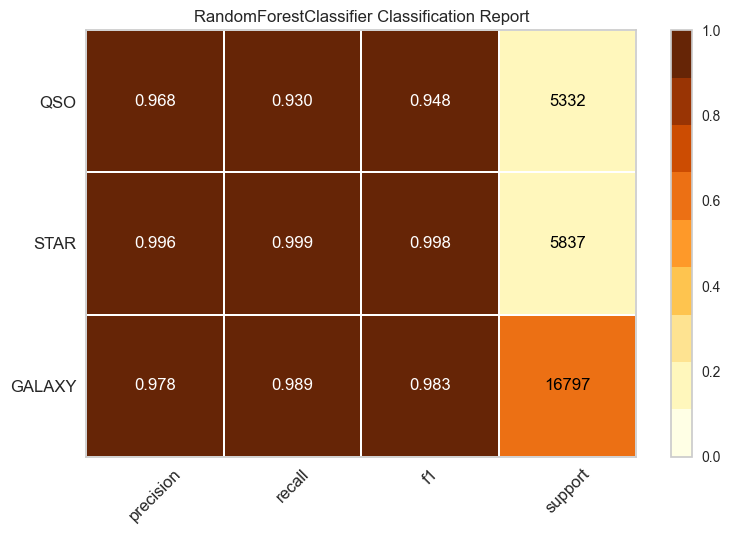

<Axes: title={'center': 'RandomForestClassifier Classification Report'}>

In [59]:
r_forest_cfr = ClassificationReport(clf, classes=classes, support=True, cmap='YlOrBr')
r_forest_cfr.fit(X_train, y_train)
r_forest_cfr.score(X_test, y_test)
r_forest_cfr.show()

Le ROC AUC (Receiver Operating Characteristic Area Under the Curve) est une mesure couramment utilisée pour évaluer les performances d'un modèle de classification binaire.

Voici ce que signifie le ROC AUC :

Courbe ROC (Receiver Operating Characteristic Curve) : La courbe ROC est un graphique qui représente la relation entre le taux de vrais positifs (Sensibilité) et le taux de faux positifs (1 - Spécificité) pour différents seuils de classification. Un modèle parfait aurait une courbe ROC qui passerait par le coin supérieur gauche du graphique (100% de sensibilité et 0% de faux positifs), tandis qu'un modèle aléatoire aurait une courbe ROC qui serait une ligne droite diagonale (aucune capacité de discrimination).

Aire sous la courbe ROC (ROC AUC) : Le ROC AUC est une mesure de la performance globale du modèle, calculée comme l'aire sous la courbe ROC. Il varie de 0 à 1, où 1 indique un modèle parfait et 0,5 indique un modèle qui prédit au hasard.

Le ROC AUC est particulièrement utile car il est indépendant du seuil de classification et fournit une évaluation agrégée de la performance du modèle sur tous les seuils. Cela en fait une mesure robuste pour comparer différents modèles de classification ou pour évaluer la performance d'un modèle dans des scénarios où les coûts de faux positifs et de faux négatifs peuvent varier.

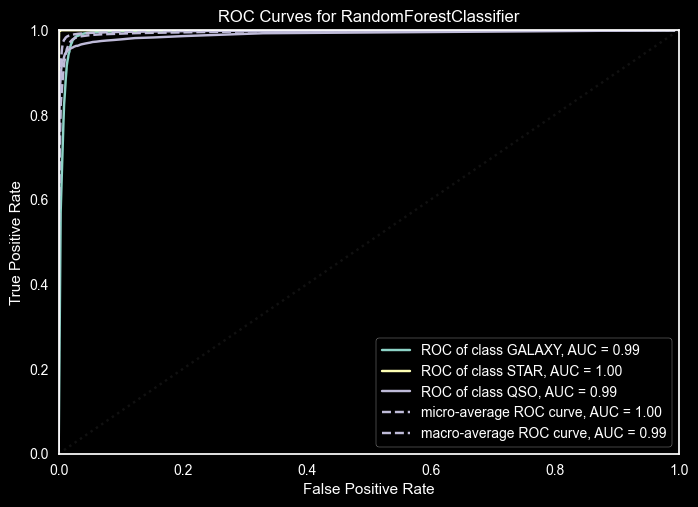

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [60]:
plt.style.use('dark_background')
plt.grid(False) # Ceci peut ne pas être nécessaire selon le style utilisé

r_forest_roc = ROCAUC( clf, classes=classes, cmap='YlOrBr')

r_forest_roc.fit(X_train, y_train)       
r_forest_roc.score(X_test, y_test)        
r_forest_roc.show() 

"Class Prediction Error" est une autre mesure utilisée pour évaluer les performances des modèles de classification. Il s'agit de la différence entre les prédictions du modèle et les valeurs réelles, souvent représentée sous forme de graphique.

Voici comment le "Class Prediction Error" est généralement représenté :

Graphique : Sur l'axe des x (horizontal), on a les classes réelles, tandis que sur l'axe des y (vertical), on a les prédictions du modèle. Chaque classe réelle est représentée par une barre verticale, et la hauteur de chaque barre indique la fréquence ou le pourcentage des prédictions du modèle pour cette classe. Idéalement, les barres devraient être alignées avec la diagonale, ce qui signifierait que les prédictions du modèle correspondent aux classes réelles.

Erreurs de classe : Les zones où les barres dévient de la diagonale représentent les erreurs de classification. Par exemple, si une barre est plus haute que la diagonale, cela signifie que le modèle surprédit cette classe. Si elle est plus basse, cela signifie qu'il la sous-prédit.

Le graphique de "Class Prediction Error" permet de visualiser facilement les performances du modèle pour chaque classe, en mettant en évidence les tendances de sur-prédiction ou de sous-prédiction. Cela peut être utile pour identifier les classes pour lesquelles le modèle a du mal à prédire correctement, ce qui peut nécessiter un examen plus approfondi et des ajustements du modèle.

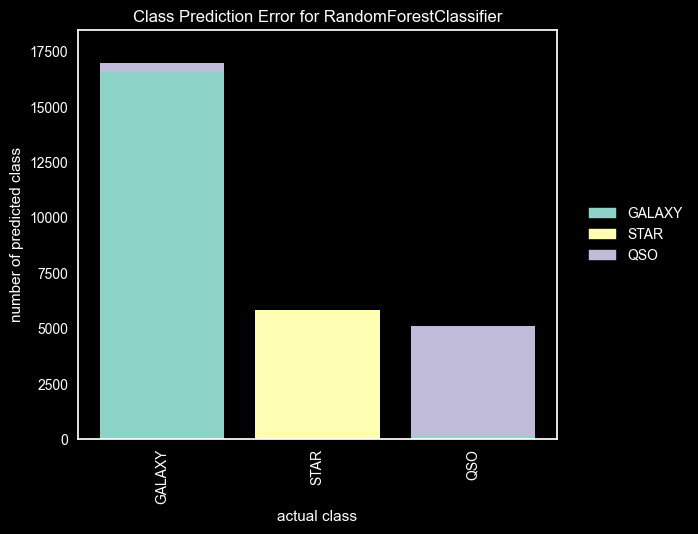

<Axes: title={'center': 'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [61]:
# Définir le style de matplotlib pour avoir un fond noir et enlever le grillage
plt.style.use('dark_background')
plt.grid(False) # Ceci peut ne pas être nécessaire selon le style utilisé

r_forest_cpe = ClassPredictionError( clf, classes=classes ,cmap='plasma')

r_forest_cpe.fit(X_train, y_train)        
r_forest_cpe.score(X_test, y_test)        
r_forest_cpe.show()   

In [62]:
svm_clf = svm.SVC(kernel='rbf', C=1, random_state=0)
svm_clf.fit(X_train,y_train)
predicted = svm_clf.predict(X_test)
score = svm_clf.score(X_test, y_test)
svm_score_ = np.mean(score)

print('Accuracy : %.3f' % (svm_score_))

Accuracy : 0.966


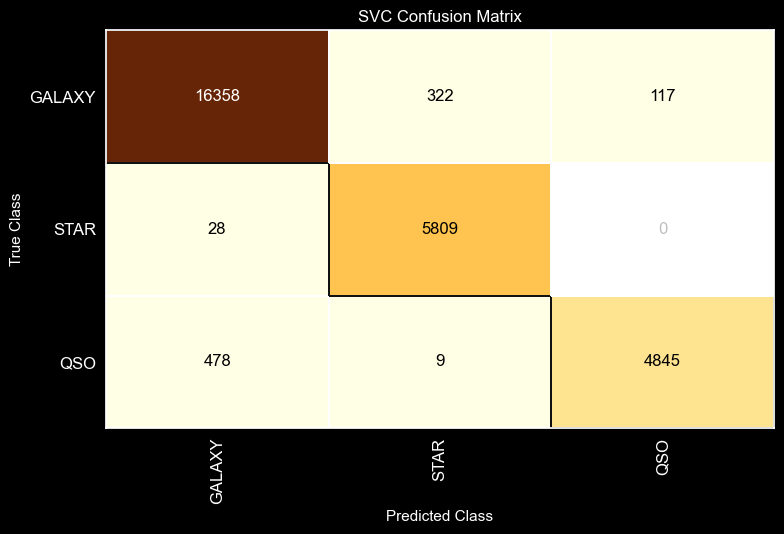

<Axes: title={'center': 'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [63]:
svm_cm = ConfusionMatrix(svm_clf, classes=classes, cmap='YlOrBr')

svm_cm.fit(X_train, y_train)
svm_cm.score(X_test, y_test)
svm_cm.show()

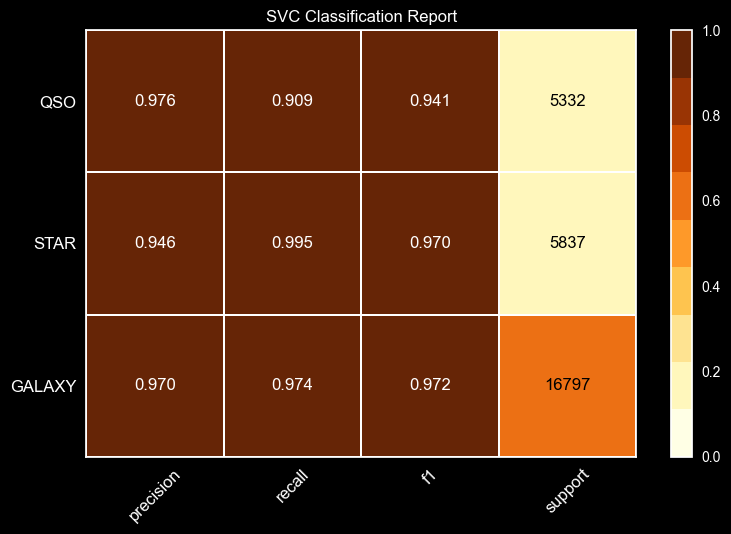

<Axes: title={'center': 'SVC Classification Report'}>

In [64]:
svm_cfr = ClassificationReport(svm_clf, classes=classes, support=True, cmap='YlOrBr')
svm_cfr.fit(X_train, y_train)
svm_cfr.score(X_test, y_test)
svm_cfr.show()


In [65]:
import plotly.graph_objs as go
import pandas as pd
from sklearn.metrics import classification_report

# Assuming svm_clf is your trained Support Vector Machine classifier
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

# Generate classification report
svm_cfr = classification_report(y_test, y_pred, target_names=classes, output_dict=True)

# Extract values from classification report
report_data = []
for label, metrics in svm_cfr.items():
    if label in classes:
        report_data.append([label, metrics['precision'], metrics['recall'], metrics['f1-score'], metrics['support']])

# Convert list to DataFrame
report_df = pd.DataFrame(report_data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])

# Create table trace with black background
table_trace = go.Table(
    header=dict(values=report_df.columns.tolist(), fill=dict(color='black'),  # Change header background color to blue
                font=dict(color='white'),  # Change header font color to white
                align='center'),
    cells=dict(values=[report_df['Class'], report_df['Precision'], report_df['Recall'], report_df['F1-Score'], report_df['Support']],
               fill=dict(color='black'),  # Change cell background color to black
               font=dict(color='white'),  # Change cell font color to white
               align='center'))

# Create figure
fig = go.Figure()

# Add table trace to figure
fig.add_trace(table_trace)

# Update layout
fig.update_layout(title='Classification Report', title_x=0.5)

# Show plot
fig.show()


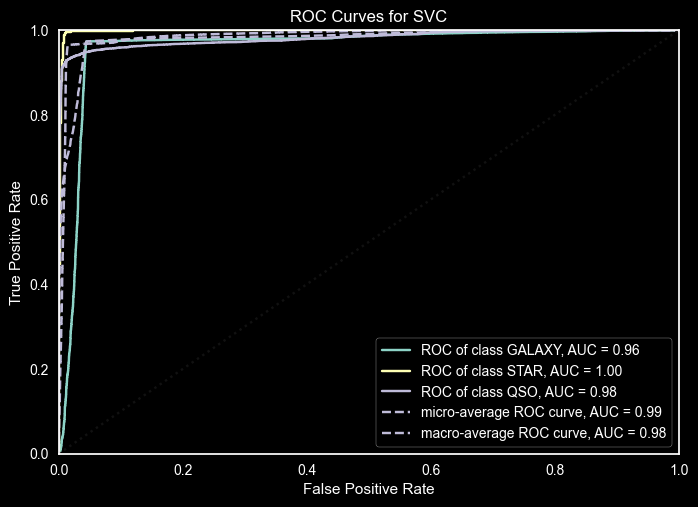

<Axes: title={'center': 'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [66]:
plt.style.use('dark_background')
plt.grid(False) # Ceci peut ne pas être nécessaire selon le style utilisé

svm_roc = ROCAUC(svm_clf, classes=classes ,cmap='plasma')

svm_roc.fit(X_train, y_train)        # Fit the training data to the svm_roc
svm_roc.score(X_test, y_test)        # Evaluate the model on the test data
svm_roc.show()                       # Finalize and render the figure

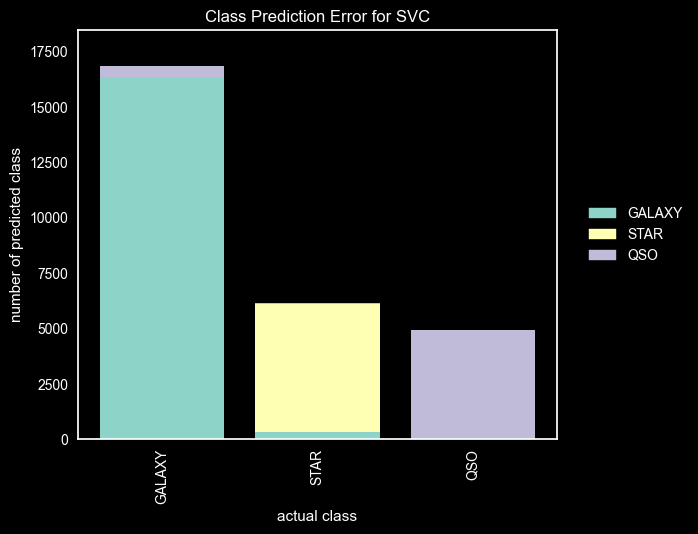

<Axes: title={'center': 'Class Prediction Error for SVC'}, xlabel='actual class', ylabel='number of predicted class'>

In [67]:
# Définir le style de matplotlib pour avoir un fond noir et enlever le grillage
plt.style.use('dark_background')
plt.grid(False) # Ceci peut ne pas être nécessaire selon le style utilisé

svm_cpe = ClassPredictionError(svm_clf, classes=classes ,cmap='plasma')

svm_cpe.fit(X_train, y_train)        # Fit the training data to the svm_cpe
svm_cpe.score(X_test, y_test)        # Evaluate the model on the test data
svm_cpe.show()                       # Draw visualization

In [68]:
# Use XGBoost classifier with default parameters
xgb_clf = xgb.XGBClassifier()
xgb_clf = xgb_clf.fit(X_train, y_train, eval_set=[(X_train, y_train)])
# Make predictions and evaluate the performance
y_pred_xgb = xgb_clf.predict(X_test)
xgb_score = xgb_clf.score(X_test, y_test)
xgb_score = np.mean(xgb_score)

print('Accuracy : %.3f' % (xgb_score))

[0]	validation_0-mlogloss:0.73285
[1]	validation_0-mlogloss:0.52390
[2]	validation_0-mlogloss:0.38952
[3]	validation_0-mlogloss:0.29924
[4]	validation_0-mlogloss:0.23576
[5]	validation_0-mlogloss:0.19046
[6]	validation_0-mlogloss:0.15749
[7]	validation_0-mlogloss:0.13339
[8]	validation_0-mlogloss:0.11576
[9]	validation_0-mlogloss:0.10271
[10]	validation_0-mlogloss:0.09325
[11]	validation_0-mlogloss:0.08612
[12]	validation_0-mlogloss:0.08047
[13]	validation_0-mlogloss:0.07625
[14]	validation_0-mlogloss:0.07293
[15]	validation_0-mlogloss:0.07055
[16]	validation_0-mlogloss:0.06875
[17]	validation_0-mlogloss:0.06726
[18]	validation_0-mlogloss:0.06605
[19]	validation_0-mlogloss:0.06493
[20]	validation_0-mlogloss:0.06405
[21]	validation_0-mlogloss:0.06295
[22]	validation_0-mlogloss:0.06223
[23]	validation_0-mlogloss:0.06140
[24]	validation_0-mlogloss:0.06063
[25]	validation_0-mlogloss:0.05975
[26]	validation_0-mlogloss:0.05898
[27]	validation_0-mlogloss:0.05835
[28]	validation_0-mlogloss:0.0

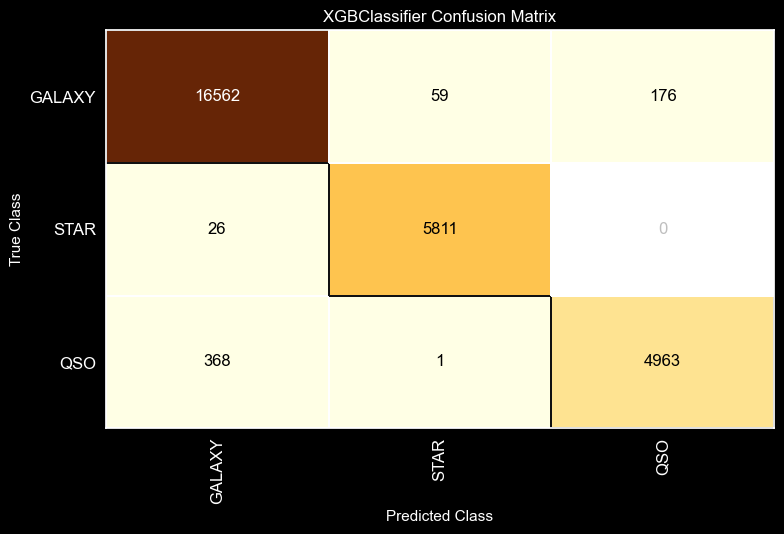

<Axes: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [69]:
xgb_cm = ConfusionMatrix(xgb_clf, classes=classes, cmap='YlOrBr')

xgb_cm.fit(X_train, y_train)
xgb_cm.score(X_test, y_test)
xgb_cm.show()

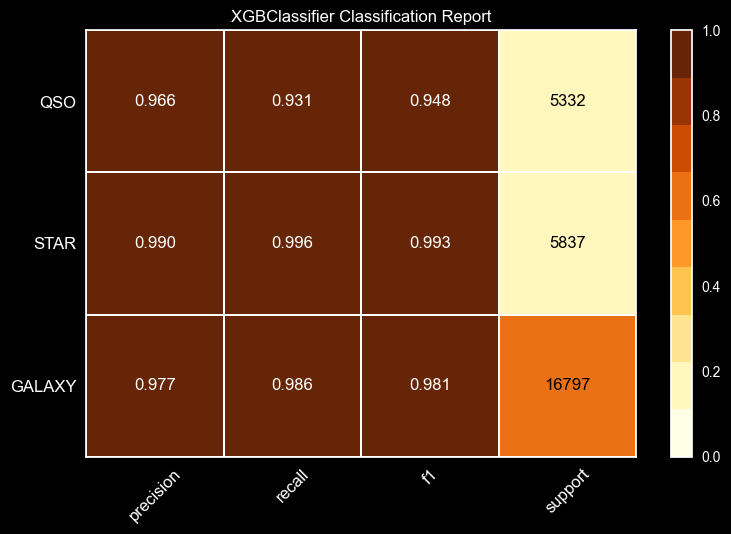

<Axes: title={'center': 'XGBClassifier Classification Report'}>

In [70]:
xgb_cfr = ClassificationReport(xgb_clf, classes=classes, support=True, cmap='YlOrBr')
xgb_cfr .fit(X_train, y_train)
xgb_cfr .score(X_test, y_test)
xgb_cfr .show()

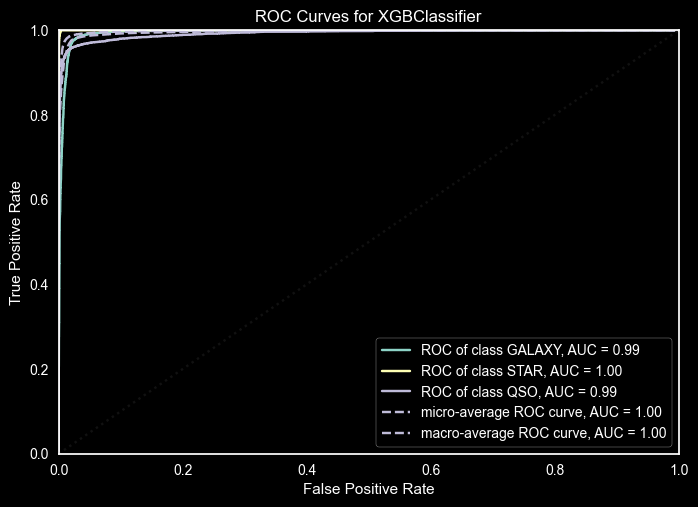

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [71]:
plt.style.use('dark_background')
plt.grid(False) # Ceci peut ne pas être nécessaire selon le style utilisé

xgb_roc = ROCAUC(xgb_clf, classes=classes ,cmap='plasma')

xgb_roc.fit(X_train, y_train)        # Fit the training data to the xgb_roc
xgb_roc.score(X_test, y_test)        # Evaluate the model on the test data
xgb_roc.show()                       # Finalize and render the figure

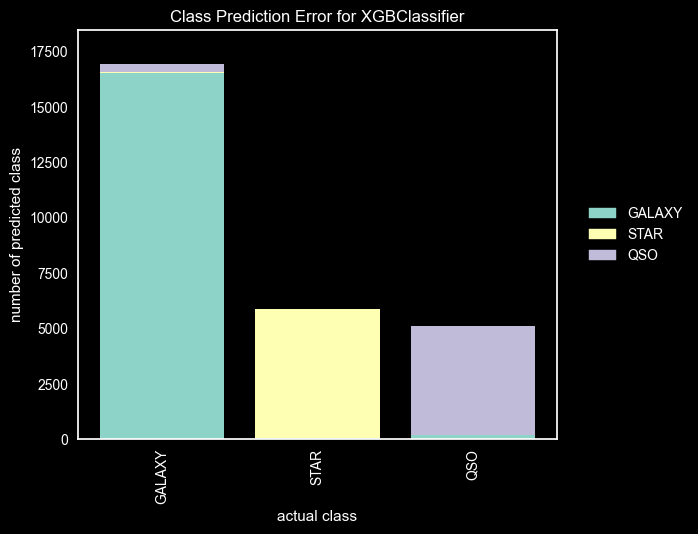

<Axes: title={'center': 'Class Prediction Error for XGBClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [73]:
# Définir le style de matplotlib pour avoir un fond noir et enlever le grillage
plt.style.use('dark_background')
plt.grid(False) # Ceci peut ne pas être nécessaire selon le style utilisé

# Créer l'instance de ClassPredictionError avec une colormap galactique
xgb_cpe = ClassPredictionError(xgb_clf, classes=classes, cmap='plasma')

xgb_cpe.fit(X_train, y_train)  # Fit the training data to the visualizer
xgb_cpe.score(X_test, y_test)  # Evaluate the model on the test data
xgb_cpe.show()                 # Finalize and render the figure